In [38]:
import csv
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from sklearn.metrics import accuracy_score,confusion_matrix
import numpy as np

print(tf.__version__) 
print("x")

2.8.0
x


In [3]:
TRAINING_FILE = "C:/Users/Shreedhar/Desktop/FINAL YEAR PROJECT/aslflutter/ASL-Python/sign_mnist_train/sign_mnist_train.csv"
VALIDATION_FILE = "C:/Users/Shreedhar/Desktop/FINAL YEAR PROJECT/aslflutter/ASL-Python/sign_mnist_test/sign_mnist_test.csv"


In [100]:
with open(TRAINING_FILE) as training_file:
    line = training_file.readline()
    print(f"First line (header) looks like this:\n{line}")
    line = training_file.readline()
    print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

In [101]:
def parse_data_from_input(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=',')    
        imgs = []
        labels = []
        next(reader, None)
        for row in reader:
            label = row[0]
            data = row[1:]
            img = np.array(data).reshape((28, 28))

            imgs.append(img)
            labels.append(label)

    images = np.array(imgs).astype(float)
    labels = np.array(labels).astype(float)
    print("done")
    return images, labels

In [102]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape}")
print(f"Training labels has shape: {training_labels.shape}")
print(f"Validation images has shape: {validation_images.shape}")
print(f"Validation labels has shape: {validation_labels.shape}")

done
done
Training images has shape: (27455, 28, 28)
Training labels has shape: (27455,)
Validation images has shape: (7172, 28, 28)
Validation labels has shape: (7172,)


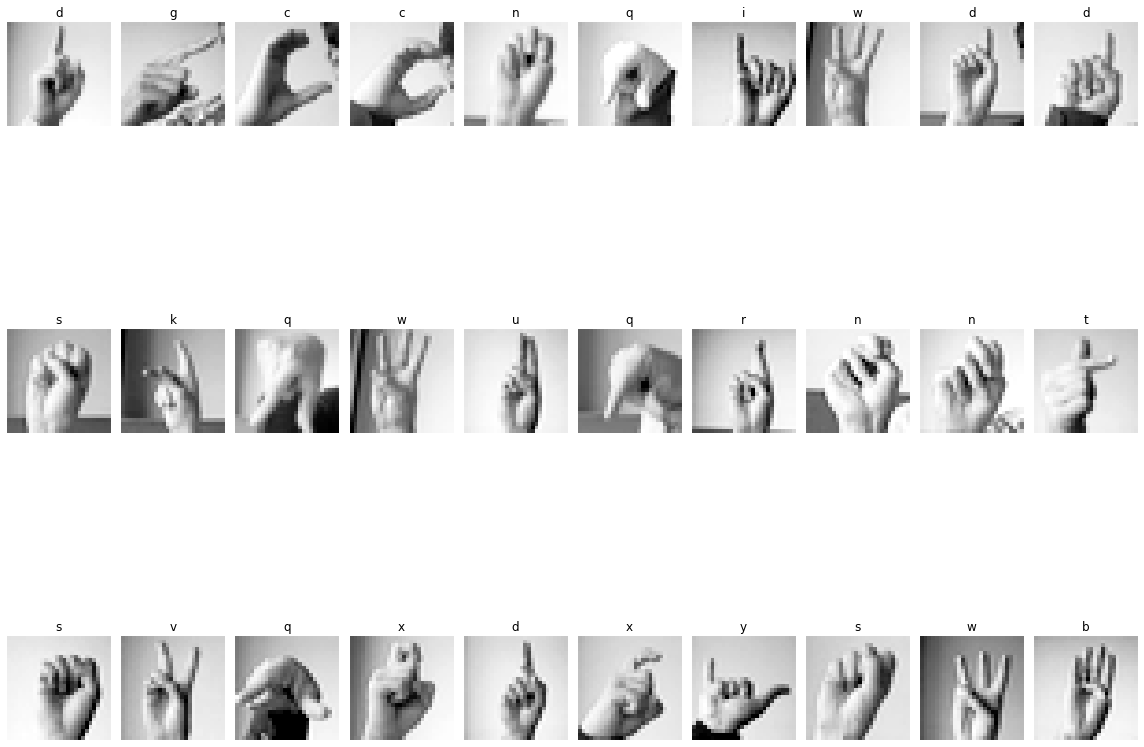

In [103]:
# Plot a sample of 30 images from the training set
def plot_categories(training_images, training_labels):
    fig, axes = plt.subplots(3, 10, figsize=(16, 15))
    axes = axes.flatten()
    letters = list(string.ascii_lowercase)

    for k in range(30):
        img = training_images[k]
        img = np.expand_dims(img, axis=-1)
        img = array_to_img(img)
        ax = axes[k]
        ax.imshow(img, cmap="Greys_r")
        ax.set_title(f"{letters[int(training_labels[k])]}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

plot_categories(training_images, training_labels)

In [104]:
train_df = pd.read_csv(TRAINING_FILE)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [105]:
train_df.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [106]:
train_df.label.value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
3     1196
14    1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

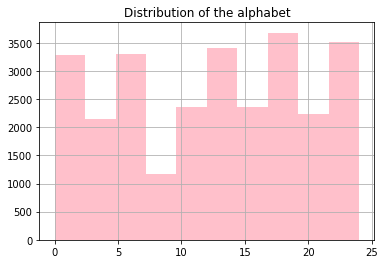

In [107]:
train_df.label.hist(color='pink',bins=10)
plt.title("Distribution of the alphabet")
plt.show()

In [116]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    training_images = np.expand_dims(training_images, axis=3)
    validation_images = np.expand_dims(validation_images, axis=3)

  # Instantiate the ImageDataGenerator class and also we need to normalize pixel values and set arguments to augment the images (if desired)
    train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
    train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  

    validation_datagen = ImageDataGenerator(
    rescale=1 / 255)

 
    validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 


    return train_generator, validation_generator
    

In [117]:
# Test our generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


In [ ]:
##Coding the CNN
def create_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')])
  

    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
   
  
    return model

In [ ]:
model = create_model()

In [ ]:
# Train our model
history = model.fit(train_generator,
                    epochs=2,
                    validation_data=validation_generator)

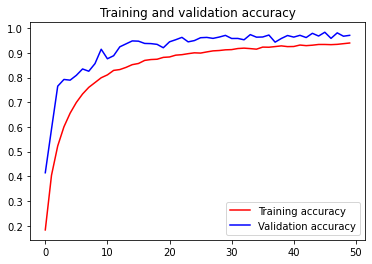

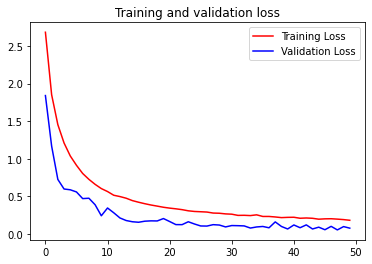

In [30]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
model.save_weights("Aslmodel.h5")


In [18]:
import tensorflow as tf

model = tf.keras.models.load_model('Aslmodel.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x000002B16ABEAB80>.

In [32]:
model.save("AslModel-1.h5")

In [17]:
import tensorflow as tf

model = tf.keras.models.load_model('Aslmodel-1.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\SHREED~1\AppData\Local\Temp\tmp1phswt8h\assets


1263080

In [29]:
import pandas as pd
test_data = pd.read_csv(VALIDATION_FILE)
print(test_data.shape)
test_data.head()

train_data = pd.read_csv(TRAINING_FILE)



(7172, 785)


In [5]:
import tensorflow as tf

model = tf.keras.models.load_model('Aslmodel-1.h5')

In [13]:

del test_data['label']

ValueError: cannot reshape array of size 5622848 into shape (64,64,1)

In [15]:
def preprocess_image(x):
    
    
    x = x/255
    x = x.reshape(-1,28,28,1) # convertin it into 28 x 28 gray scaled image
    
    return x

In [16]:
test_x = preprocess_image(test_data.values)
train_data = pd.read_csv(TRAINING_FILE)

In [19]:
model = tf.keras.models.load_model('Aslmodel-1.h5')

In [20]:
predictions = model.predict(test_x)

In [21]:
print(predictions)

[[2.1752533e-09 7.5041839e-09 3.2998043e-06 ... 1.5053806e-09
  4.1102107e-06 1.4443876e-08]
 [3.8645635e-11 2.3475422e-07 1.5674156e-12 ... 4.9437108e-07
  2.7689058e-14 1.5239163e-08]
 [2.5006898e-12 1.1727354e-13 1.2095907e-13 ... 8.5987164e-12
  2.3351820e-10 3.7851753e-09]
 ...
 [1.0783212e-09 1.1778512e-11 9.9999726e-01 ... 1.5822468e-12
  2.2999822e-09 9.2616149e-12]
 [2.8770449e-04 9.3646651e-07 9.1587839e-07 ... 1.5897148e-09
  1.1213163e-07 1.6853921e-08]
 [4.6445567e-10 2.9328100e-12 9.9999738e-01 ... 8.8117892e-13
  6.2073091e-10 1.7954120e-12]]


In [25]:
def predictions_to_labels(pred):
    labels =[]
    for p in pred:
        labels.append(unique_labels[np.argmax(p)])
    return labels

In [34]:
y_pred_labels = predictions_to_labels(predictions)
y_test_labels = predictions_to_labels(y_test)

In [30]:
y_train = train_data['label']
y_test = test_data['label']


In [33]:
unique_labels = y_train.unique()
unique_labels = np.sort(unique_labels)
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [41]:
print(y_pred_labels[7])
print(y_test_labels[7])
accuracy_score(y_test_labels,y_pred_labels)

14
0


0.04559397657557167